# Modeling COVID-19 Pandemic in New York State with Epydemix

In this tutorial we will develop an epidemic models for COVID-19 and we will calibrate it to real data on weekly deaths during the first wave in New York State, US. 

Let's import needed packages:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from epydemix.model import EpiModel, simulate
from epydemix.population import load_epydemix_population
from epydemix.visualization import plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import calibrate
from epydemix.utils import compute_simulation_dates, convert_to_2Darray
from epydemix.calibration.metrics import wmape
import numpy as np 
from datetime import datetime
from scipy import stats 

Second, we import and plot the epidemic data on weekly deaths that we want to model:

2020-03-08 00:00:00 2020-08-02 00:00:00


,date,data,new_cases
1,2020-03-08,0,45
2,2020-03-15,8,2931
3,2020-03-22,224,20475
4,2020-03-29,1515,30144
5,2020-04-05,4271,36099
6,2020-04-12,5423,34171
7,2020-04-19,4056,22962
8,2020-04-26,2710,18273
9,2020-05-03,1806,13108
10,2020-05-10,1084,7890


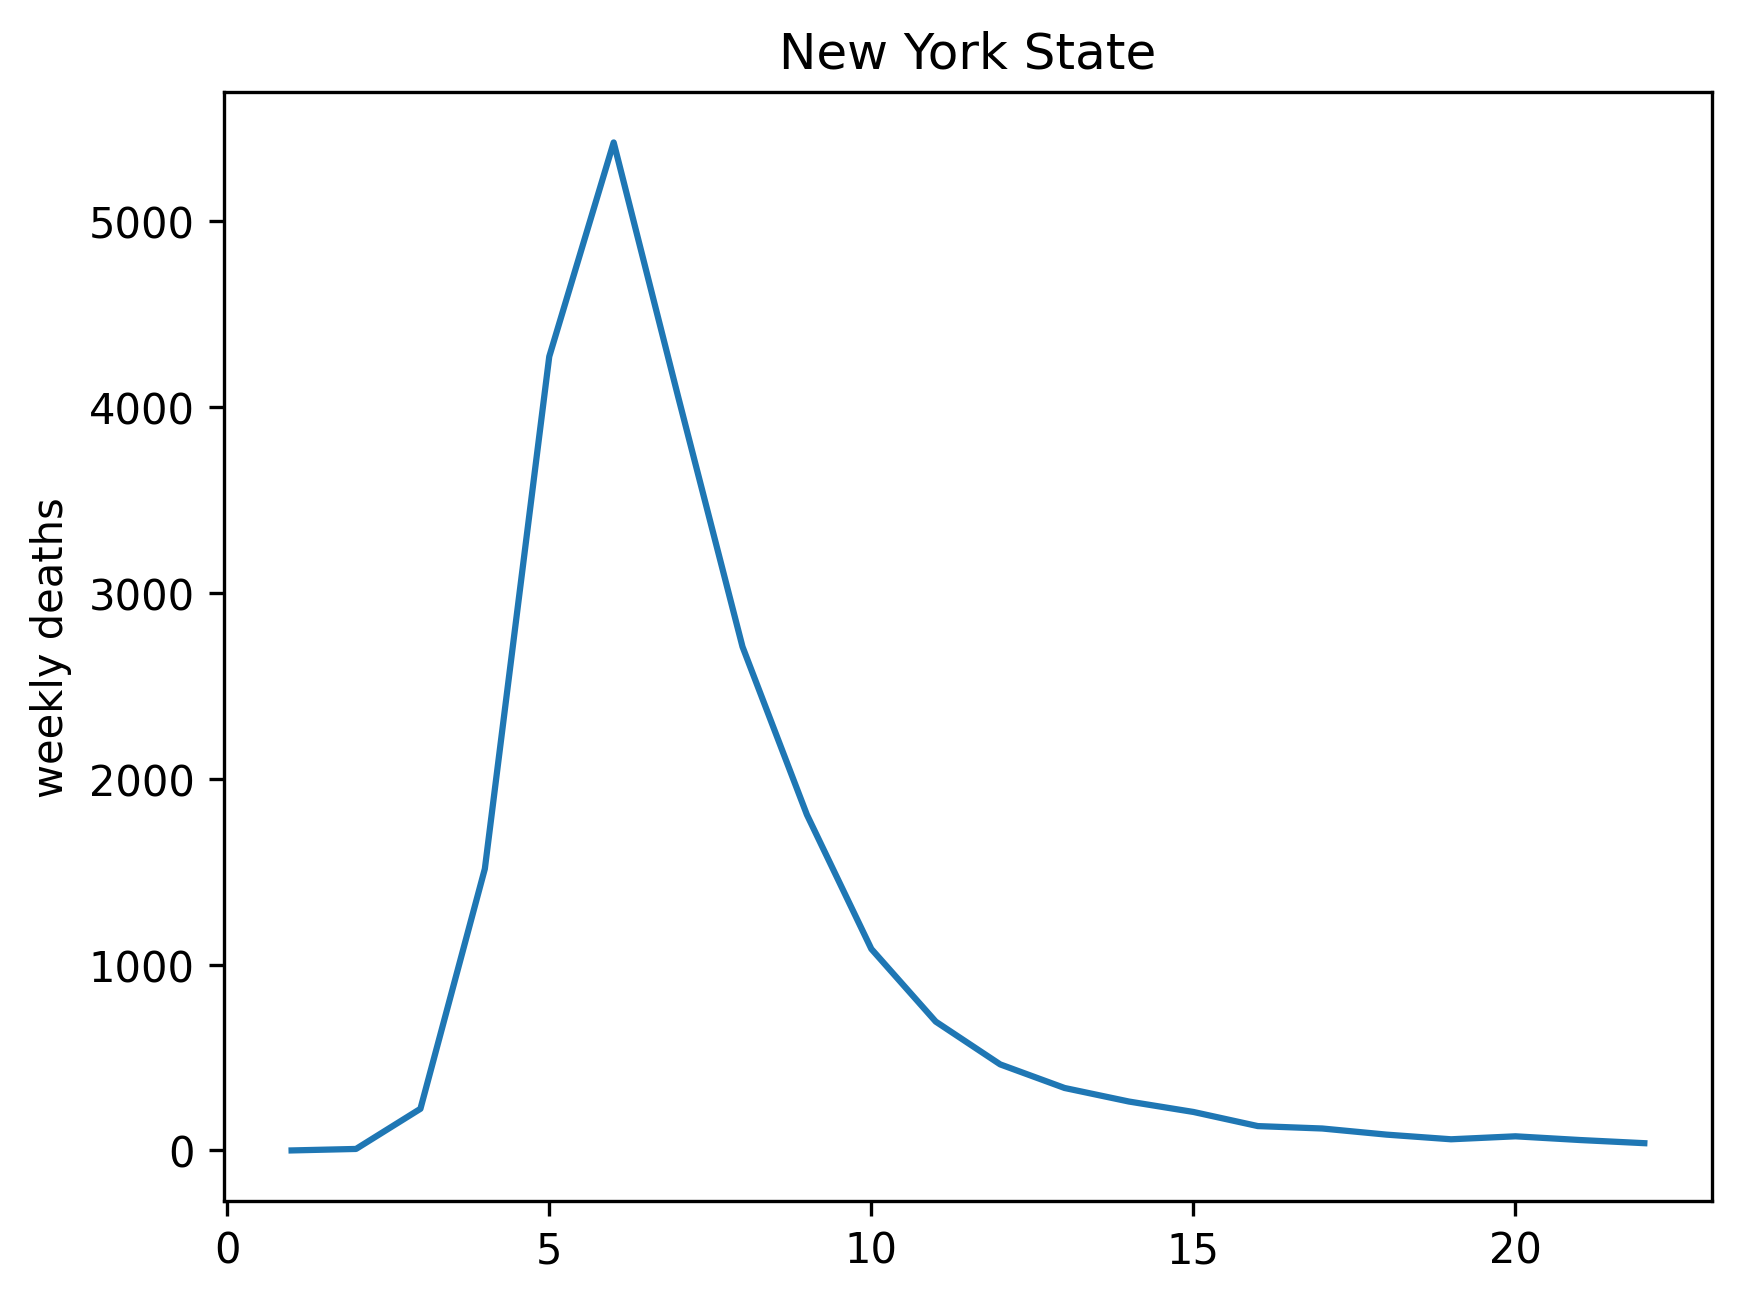

In [2]:
# import epidemic data 
#epi_data = pd.read_csv("./data/ny_state/NY_deaths.csv")
epi_data = pd.read_csv("./data/ny_state/new_york/epi-data/epi_data.csv")
epi_data.rename(columns={"new_deaths": "data"}, inplace=True)
epi_data.date = pd.to_datetime(epi_data.date)
epi_data.set_index("date", inplace=True)
epi_data = epi_data.resample("W").sum()
epi_data.reset_index(inplace=True)
epi_data = epi_data.loc[(epi_data.date >= datetime(year=2020, month=3, day=8)) & (epi_data.date <= datetime(year=2020, month=8, day=2))]

fig, ax = plt.subplots(dpi=300)
epi_data.data.plot(ax=ax, title="New York State", ylabel="weekly deaths")
print(epi_data.date.min(), epi_data.date.max())

epi_data

Then, we import mobility data from the COVID-19 Community Mobility Report published by Google. Since the first wave of COVID-19 was controlled via the implementation of non-pharmaceutical interventions, we need to account for this into our model. We will use mobility data to compute a contact reduction parameter $r(t)$ that will modulate the transmission rate of our epidemic model. For more detail on similar approaches see REFS:

<Axes: title={'center': 'Contact reductions in New York State - COVID-19 First wave'}, xlabel='date', ylabel='$r(t)$'>

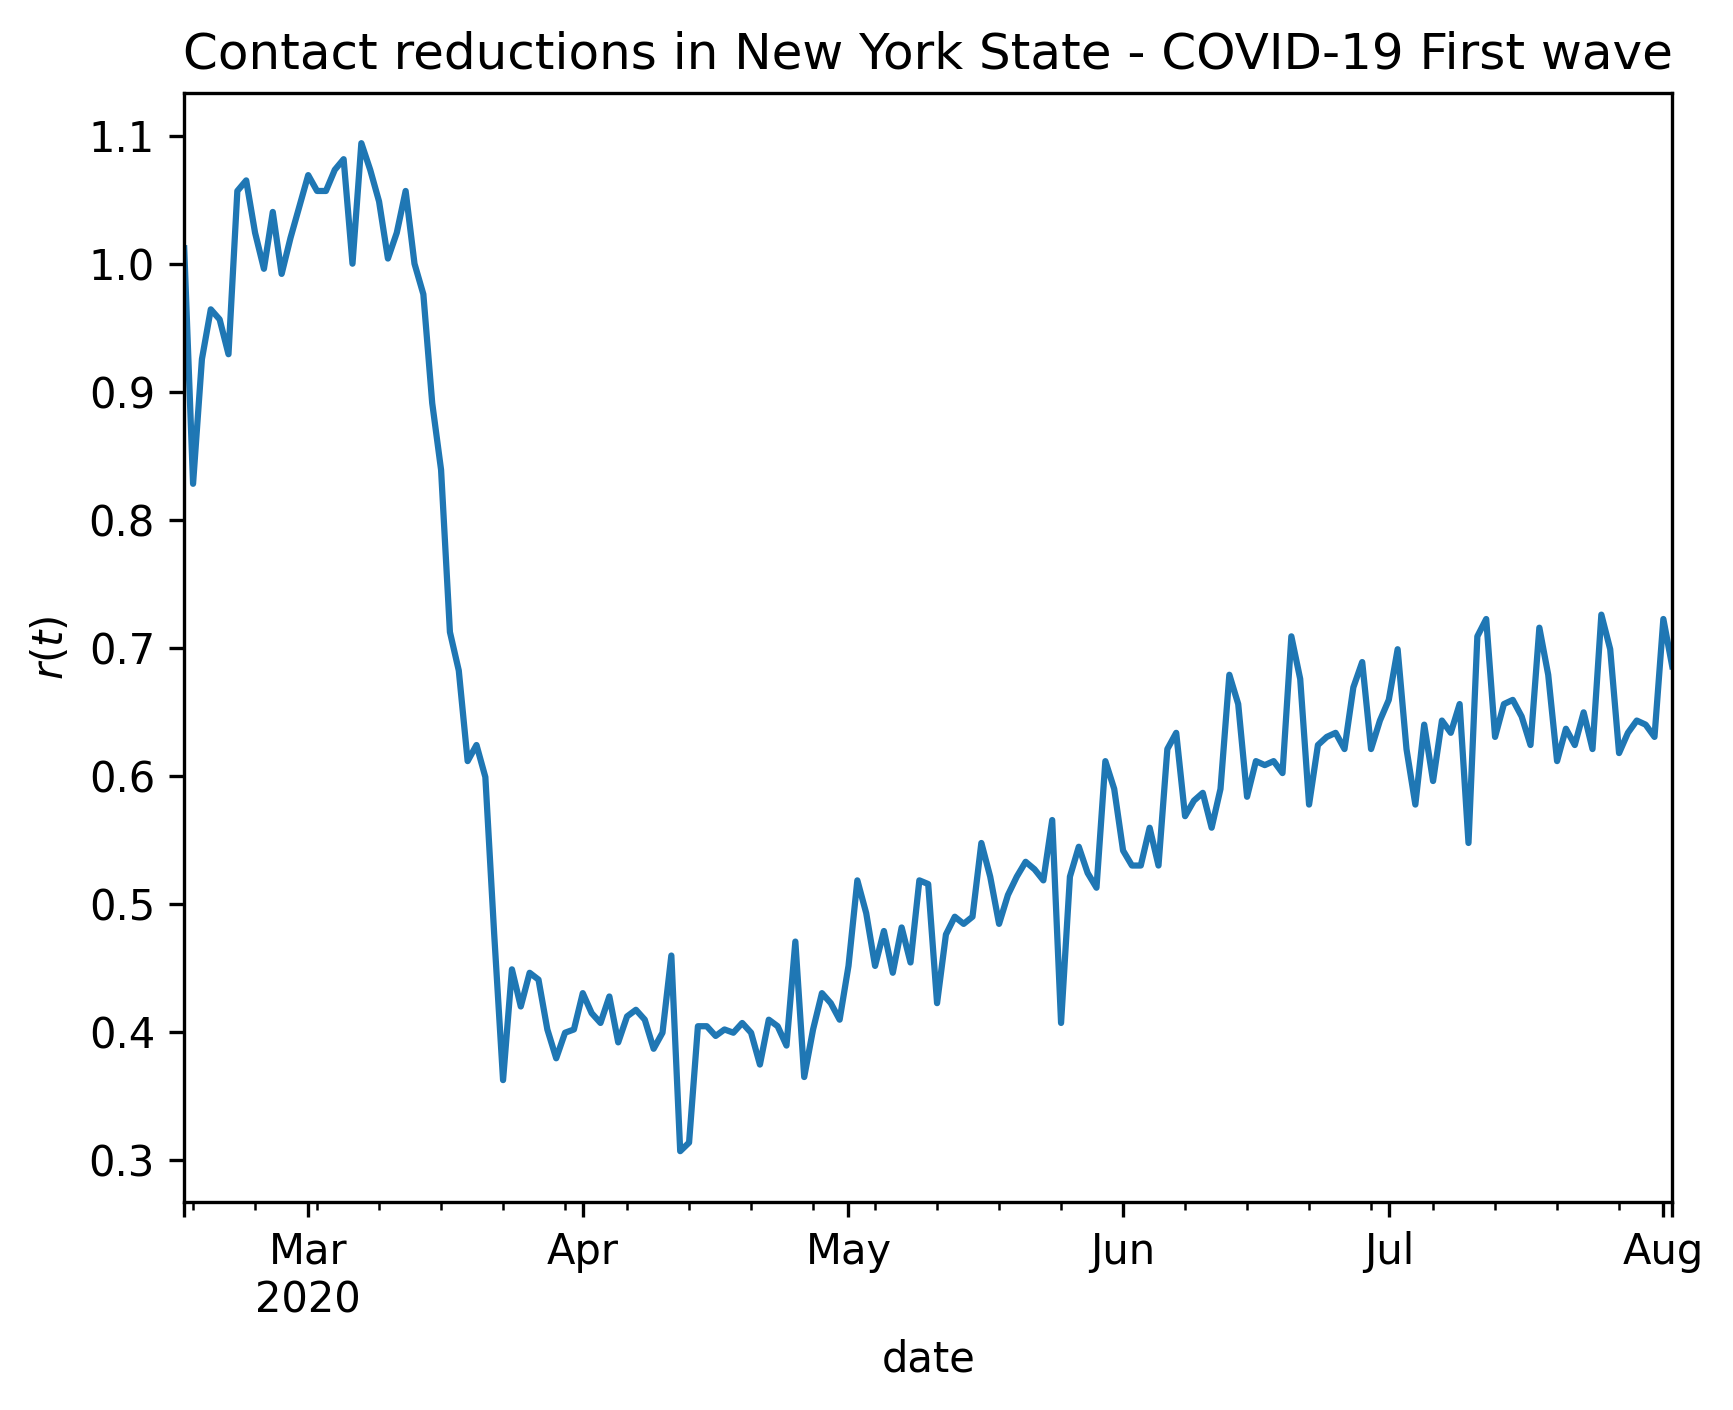

In [3]:
def compute_contact_reductions(mob_data, columns):
    return pd.DataFrame(data={'date': mob_data.date, 'r': (1 + mob_data[columns].mean(axis=1) / 100)**2})

# import google data and compute contacts reduction
mob_data = pd.read_csv(f'./data/ny_state/NY_google.csv')
#mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
mob_data.date = pd.to_datetime(mob_data.date)
mob_data = mob_data.loc[(mob_data.date >= datetime(year=2020, month=2, day=16)) & (mob_data.date <= datetime(year=2020, month=8, day=2))]
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])
contact_reductions.index = pd.to_datetime(contact_reductions.date)

fig, ax = plt.subplots(dpi=300)
contact_reductions.r.plot(ax=ax, title="Contact reductions in New York State - COVID-19 First wave", ylabel="$r(t)$")

We are ready to create the epidemic model. We will implement a SEIR-like model, with the addition of compartments to represent COVID-19 deaths. The model follows this schema:

MODEL SCHEMA

The multiple $D_i$ compartments are introduced to make the transitions from recovery to deaths Erlang distributed. 

In [4]:
popu = pd.read_csv("./data/ny_state/new_york/population-data/pop_data_Nk.csv")


In [5]:
# define Epydemix model
model = EpiModel(compartments=["S", "E", "I", "R", 
                               "D0", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10"])


# set population
population_nys = load_epydemix_population("United_States_New_York", 
                                          age_group_mapping={"0-9": np.arange(0, 10).astype(str),
                                                            "10-19": np.arange(10, 20).astype(str),
                                                            "20-24": np.arange(20, 25).astype(str),
                                                            "25-29": np.arange(25, 30).astype(str),
                                                            "30-39": np.arange(30, 40).astype(str),
                                                            "40-49": np.arange(40, 50).astype(str),
                                                            "50-59": np.arange(50, 60).astype(str),
                                                            "60-69": np.arange(60, 70).astype(str),
                                                            "70-79": np.arange(70, 80).astype(str), 
                                                            "80+": np.concatenate((np.arange(80, 84), ["84+"])).astype(str)})
population_nys.add_population(popu.values[0], popu.columns)
model.set_population(population_nys)

model.add_parameter(parameters_dict={"beta": 0.1,
                                     #"Delta": 14, 
                                     "mu": 1. / 2.5, 
                                     "eps": 1. / 4., 
                                     "r": contact_reductions["r"].values, 
                                     "IFR": convert_to_2Darray([0.00161/100, 
                                                                0.00695/100, 
                                                                0.0309/100, 
                                                                0.0309/100, 
                                                                0.0844/100, 
                                                                0.161/100, 
                                                                0.595/100, 
                                                                1.93/100, 
                                                                4.28/100, 
                                                                7.80/100])
                                              })

model.add_transition(source="S", target="E", rate="beta*r", agent="I")
model.add_transition(source="E", target="I", rate="eps")
model.add_transition(source="I", target="R", rate="mu*(1-IFR)")
model.add_transition(source="I", target="D0", rate="mu*IFR")
model.add_transition(source="D0", target="D1", rate="10./Delta")
model.add_transition(source="D1", target="D2", rate="10./Delta")
model.add_transition(source="D2", target="D3", rate="10./Delta")
model.add_transition(source="D3", target="D4", rate="10./Delta")
model.add_transition(source="D4", target="D5", rate="10./Delta")
model.add_transition(source="D5", target="D6", rate="10./Delta")
model.add_transition(source="D6", target="D7", rate="10./Delta")
model.add_transition(source="D7", target="D8", rate="10./Delta")
model.add_transition(source="D8", target="D9", rate="10./Delta")
model.add_transition(source="D9", target="D10", rate="10./Delta")
print(model)

EpiModel(name='EpiModel')
Compartments: 15
  S, E, I, R, D0, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10
Transitions: 14
  Transitions between compartments:
    S -> E, rate: beta*r
    E -> I, rate: eps
    I -> R, rate: mu*(1-IFR)
    I -> D0, rate: mu*IFR
    D0 -> D1, rate: 10./Delta
    D1 -> D2, rate: 10./Delta
    D2 -> D3, rate: 10./Delta
    D3 -> D4, rate: 10./Delta
    D4 -> D5, rate: 10./Delta
    D5 -> D6, rate: 10./Delta
    D6 -> D7, rate: 10./Delta
    D7 -> D8, rate: 10./Delta
    D8 -> D9, rate: 10./Delta
    D9 -> D10, rate: 10./Delta
Parameters: 5
  Model parameters:
    beta: 0.1
    mu: 0.4
    eps: 0.25
    r: [1.012036 0.8281   0.925444 0.964324 0.956484 0.929296 1.056784 1.065024
 1.024144 0.996004 1.0404   0.992016 1.0201   1.044484 1.069156 1.056784
 1.056784 1.073296 1.0816   1.       1.094116 1.073296 1.048576 1.004004
 1.024144 1.056784 1.       0.976144 0.891136 0.839056 0.712336 0.682276
 0.611524 0.6241   0.599076 0.4761   0.362404 0.4489   0.419904 0.44622

In [6]:
def apply_seasonality(start_date, end_date, seasonality_min, seasonality_max=1):
    seasonality_factors = []
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    for day in pd.date_range(start_date, end_date):
        day_max=datetime(day.year, 1, 15)
        s_r = seasonality_min / seasonality_max
        seasonality_factors.append(0.5 * ((1 - s_r) * np.sin(2 * np.pi / 365 * (day - day_max).days + 0.5 * np.pi) + 1 + s_r))
    return np.array(seasonality_factors)

def compute_beta1(C, mu, R0): 
    return R0 * mu / np.linalg.eigvals(C).real.max()

def compute_beta(R0, mu, Nk, C):
    C_hat = np.zeros((C.shape[0], C.shape[1]))
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            C_hat[i, j] = (Nk[i] / Nk[j]) * C[i, j]
    return R0 * mu / (np.max([e.real for e in np.linalg.eig(C_hat)[0]]))

def compute_R0(beta, mu, C): 
    return beta * np.linalg.eigvals(C).real.max() / mu


C = np.sum([c for _, c in model.population.contact_matrices.items()], axis=0)

We are almost ready for the calibration:

In [7]:
def custom_initial_conditions(epimodel, I0): 
    iic = {"S": np.zeros(epimodel.population.Nk.shape), 
           "E": np.zeros(epimodel.population.Nk.shape), 
           "I": np.zeros(epimodel.population.Nk.shape), 
           "R": np.zeros(epimodel.population.Nk.shape)}
    
    # distribute intial infected and recovered among age groups
    for age in range(len(epimodel.population.Nk)):
        # I
        inf_t0_age = int(I0 * epimodel.population.Nk[age] / np.sum(epimodel.population.Nk))
        iic["I"][age] = int(int(inf_t0_age) * (1 / epimodel.parameters["mu"]) / ((1 / epimodel.parameters["mu"]) + (1 / epimodel.parameters["eps"])))
        # E 
        iic["E"][age] = inf_t0_age - iic["I"][age]
        # S
        iic["S"][age] = epimodel.population.Nk[age] - (iic["I"][age] + iic["E"][age])
    #infected_by_age = np.random.multinomial(I0, epimodel.population.Nk / epimodel.population.Nk.sum())
    #return {"S": epimodel.population.Nk - infected_by_age, 
    #        "E": (infected_by_age / 2).astype(int),
    #         "I": (infected_by_age / 2).astype(int)}
    return iic

def simulate_wrapper(parameters): 
    initial_conditions = custom_initial_conditions(parameters["epimodel"], parameters["I0"])
    parameters.update({"initial_conditions_dict": initial_conditions})
    # compute beta from R0 
    beta0 = compute_beta(parameters["R0"], parameters["epimodel"].parameters["mu"], parameters["epimodel"].population.Nk, C)
    # compute seasonality factor
    sesonal_factor = apply_seasonality(parameters["start_date"],  parameters["end_date"], parameters["seasonality_min"])
    parameters.update({"beta": beta0 * sesonal_factor})
    results = simulate(**parameters)
    # apply detection rate
    deaths = (results.transitions["D9_to_D10_total"] * parameters["detection_rate"]).astype(int)
    return {"data": deaths[3:]}


priors = {"R0": stats.uniform(1.5, 6.0 - 1.5), 
          "Delta": stats.randint(7, 28),
          "I0": stats.randint(10, 9990),
          "seasonality_min": stats.uniform(0.6, 1.0 - 0.6), 
          "detection_rate": stats.uniform(0.5, 1.0 - 0.5)}

simulation_dates = compute_simulation_dates(start_date=epi_data.date.values[0], end_date=epi_data.date.values[-1])
parameters = {"epimodel": model, 
              #"start_date": epi_data.date.values[0], 
              "start_date": datetime(year=2020, month=2, day=16),
              "end_date": epi_data.date.values[-1], 
              "resample_frequency": "W"}

In [8]:
results = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    distance_function=wmape,
                    parameters=parameters, 
                    observed_data={"data": epi_data["data"].values},  
                    num_particles=100, 
                    max_generations=8)

Running generation 1, epsilon: 1.0059473416864206
	Elapsed time: 00:01:35
Running generation 2, epsilon: 0.7284117846258042
	Elapsed time: 00:02:01
Running generation 3, epsilon: 0.5931044700304775
	Elapsed time: 00:01:54
Running generation 4, epsilon: 0.4774593633592956
	Elapsed time: 00:02:09
Running generation 5, epsilon: 0.3469988147646461
	Elapsed time: 00:03:08
Running generation 6, epsilon: 0.2692389095834744
	Elapsed time: 00:03:32
Running generation 7, epsilon: 0.22060193024043345
	Elapsed time: 00:14:58
Running generation 8, epsilon: 0.18891804944124618
	Elapsed time: 00:05:15


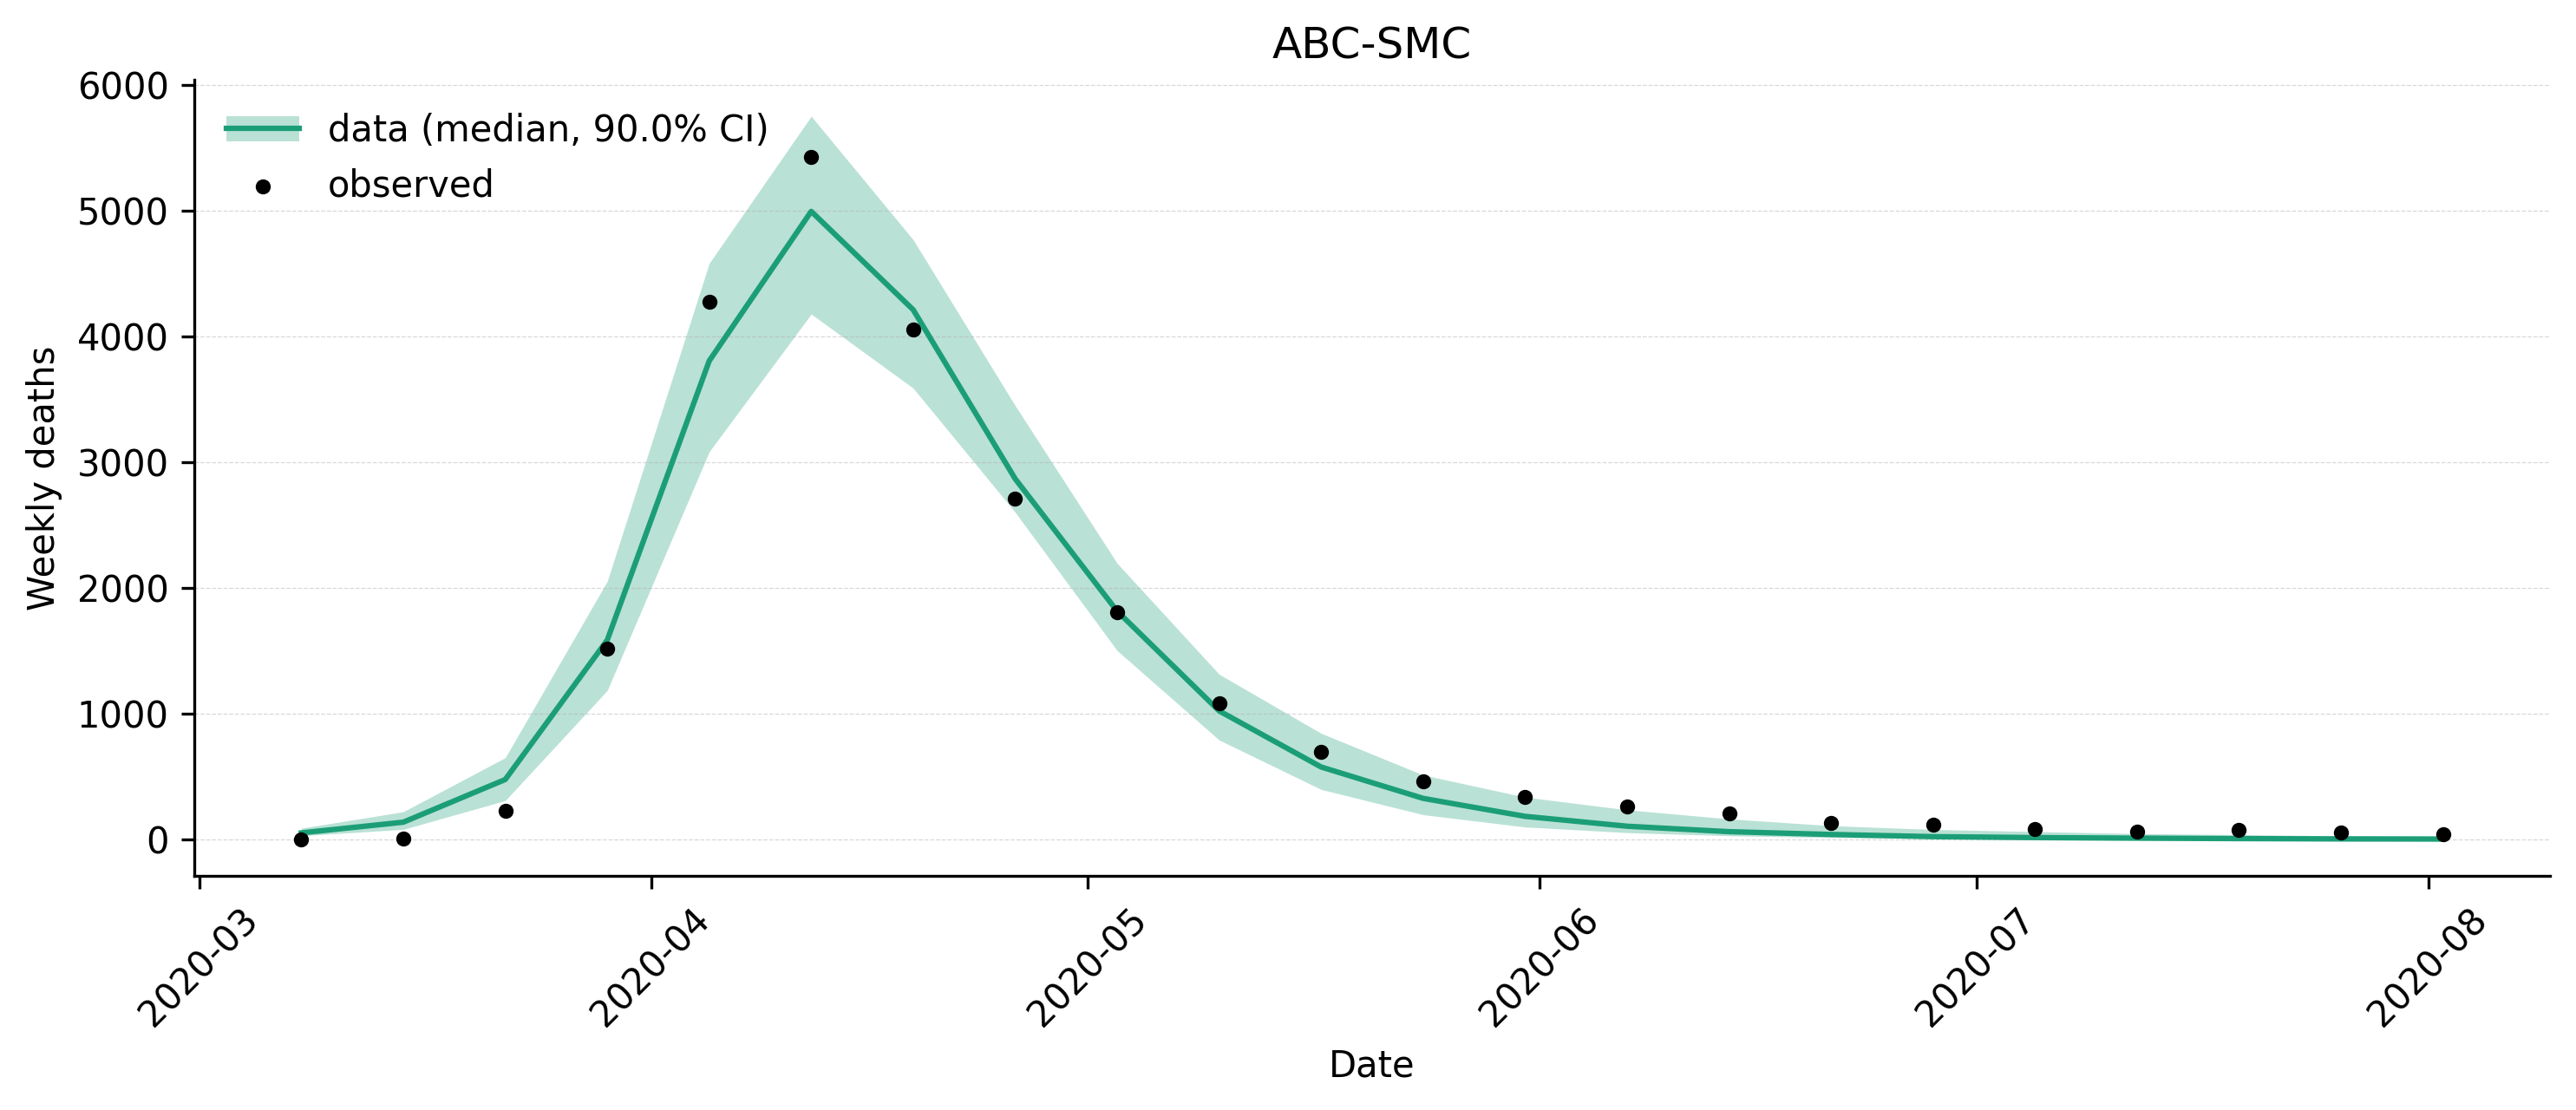

In [9]:
ax = plot_quantiles(results.get_calibration_quantiles(dates=epi_data.date.values), 
                    data=epi_data, columns="data", title="ABC-SMC", show_data=True, 
                    xlabel="Date", ylabel="Weekly deaths")   
ax.tick_params(axis='x', labelrotation=45)


In [13]:
median_epx_res = results.get_calibration_quantiles(dates=epi_data.date.values)
median_epx_res = median_epx_res.loc[median_epx_res["quantile"] == 0.5]

In [15]:
wmape({"data": epi_data.data.values}, {"data": median_epx_res.data.values})


0.12552912292583812

<Axes: xlabel='detection_rate', ylabel='Density'>

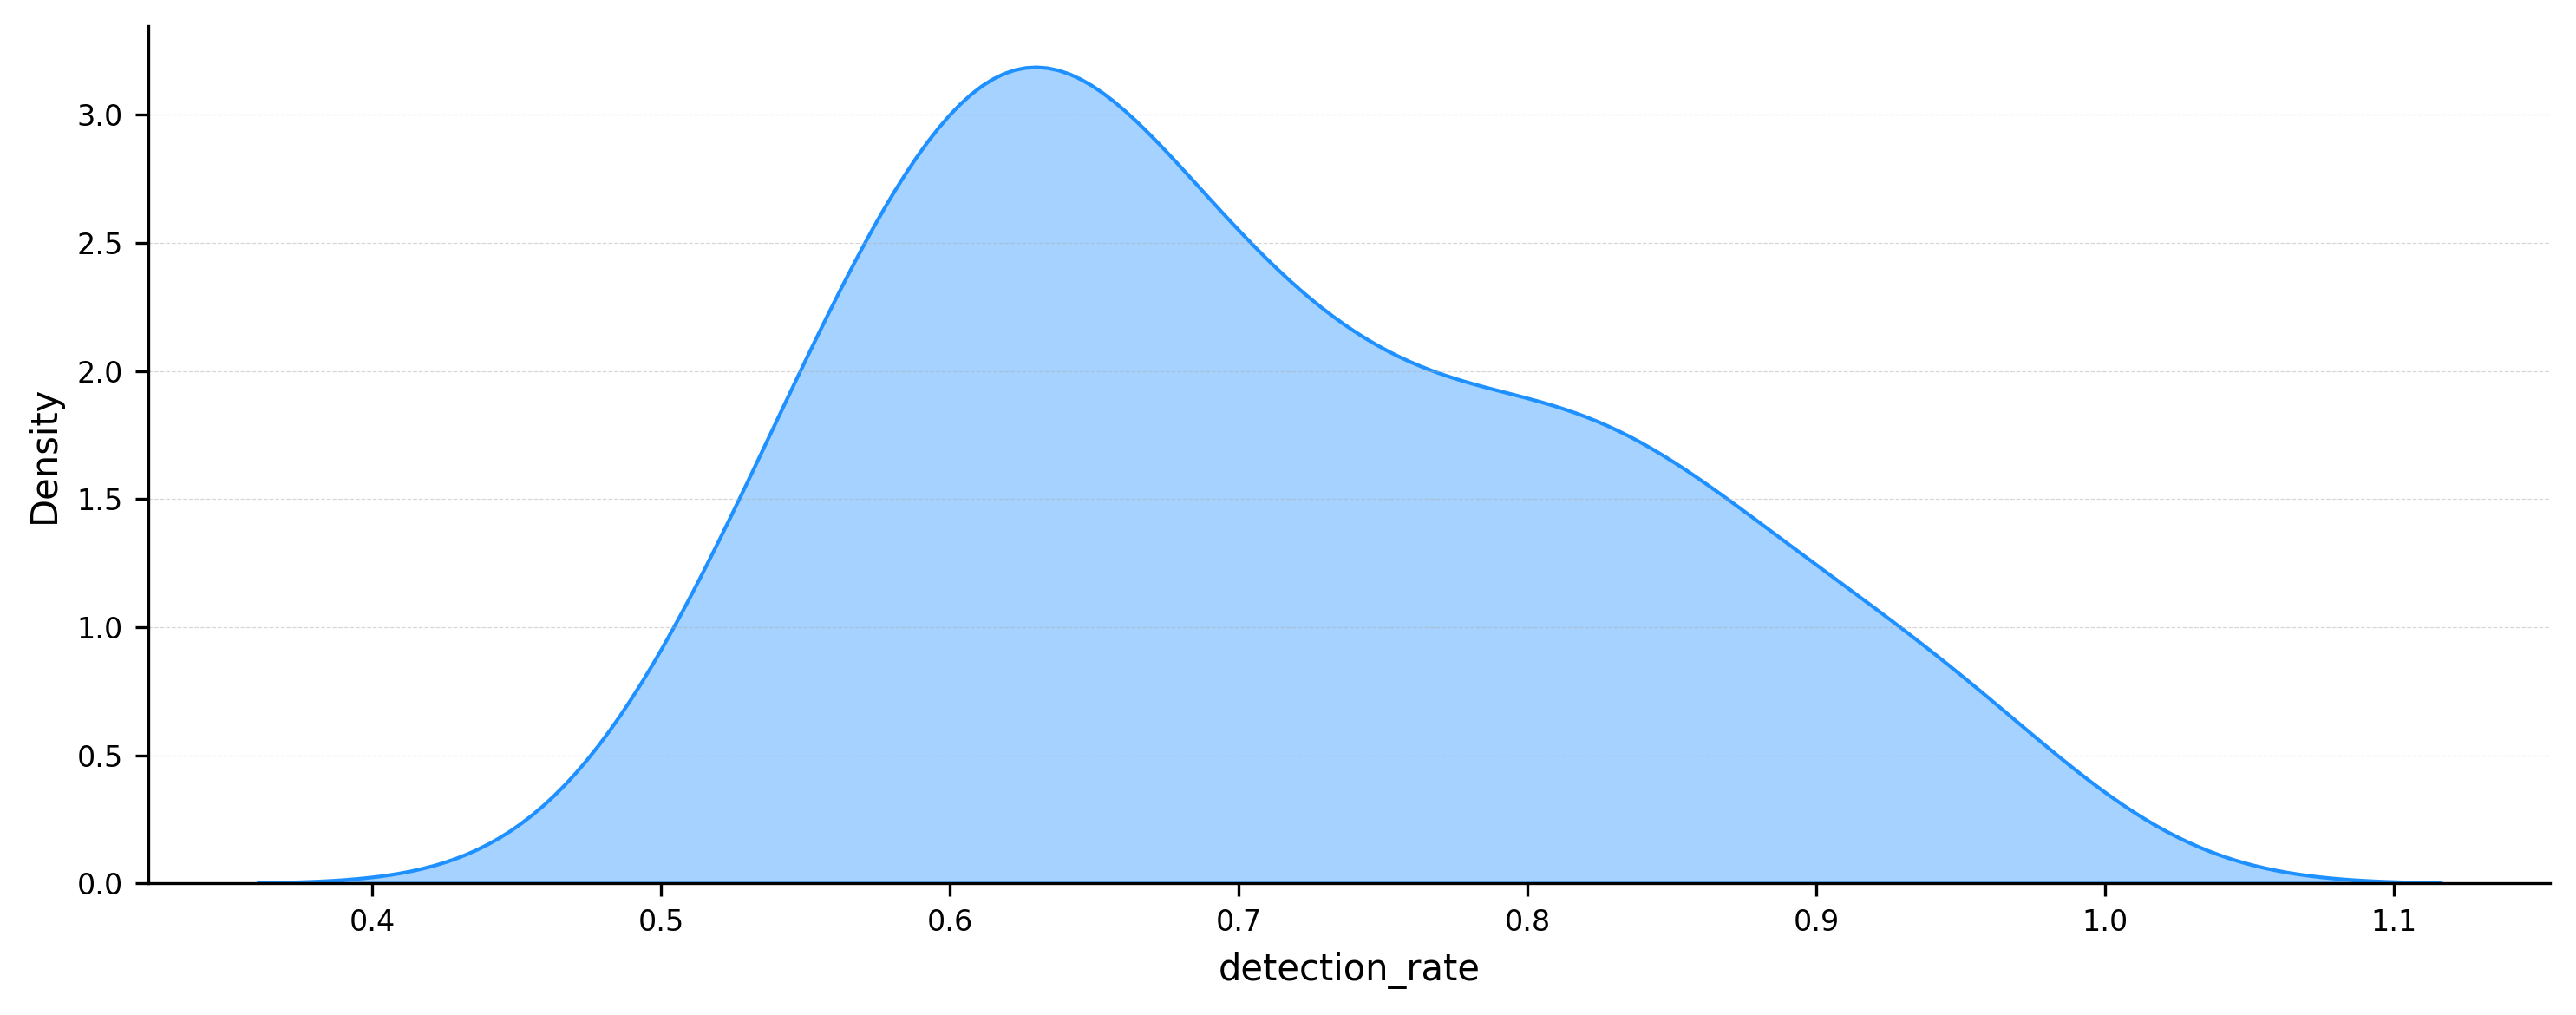

In [19]:
plot_posterior_distribution(results.get_posterior_distribution(), "detection_rate", kind="kde")

<Axes: xlabel='R0', ylabel='Density'>

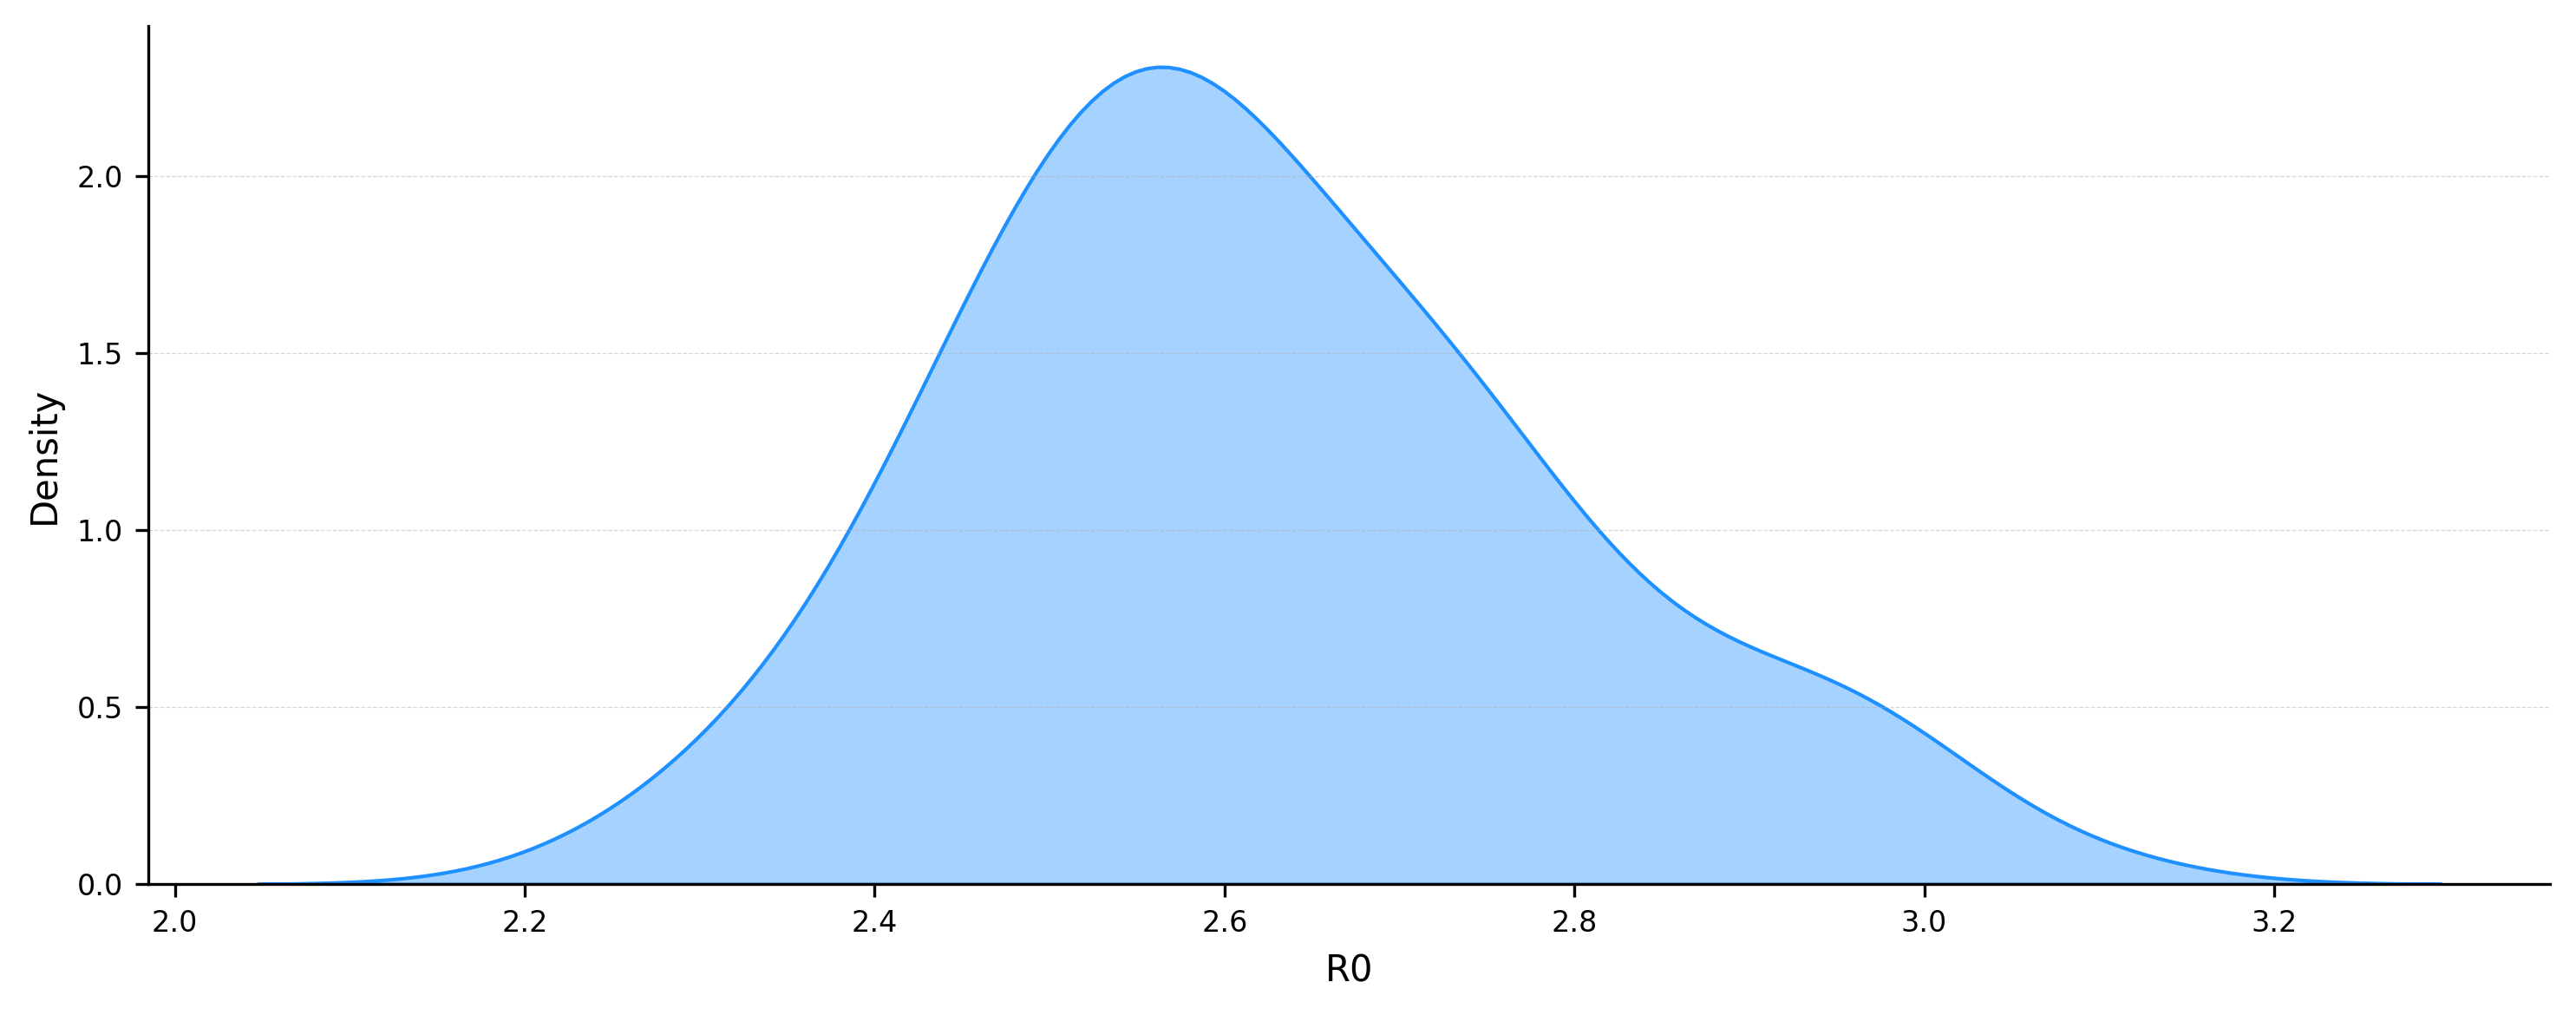

In [16]:
plot_posterior_distribution(results.get_posterior_distribution(), "R0", kind="kde")

<Axes: xlabel='seasonality_min', ylabel='Density'>

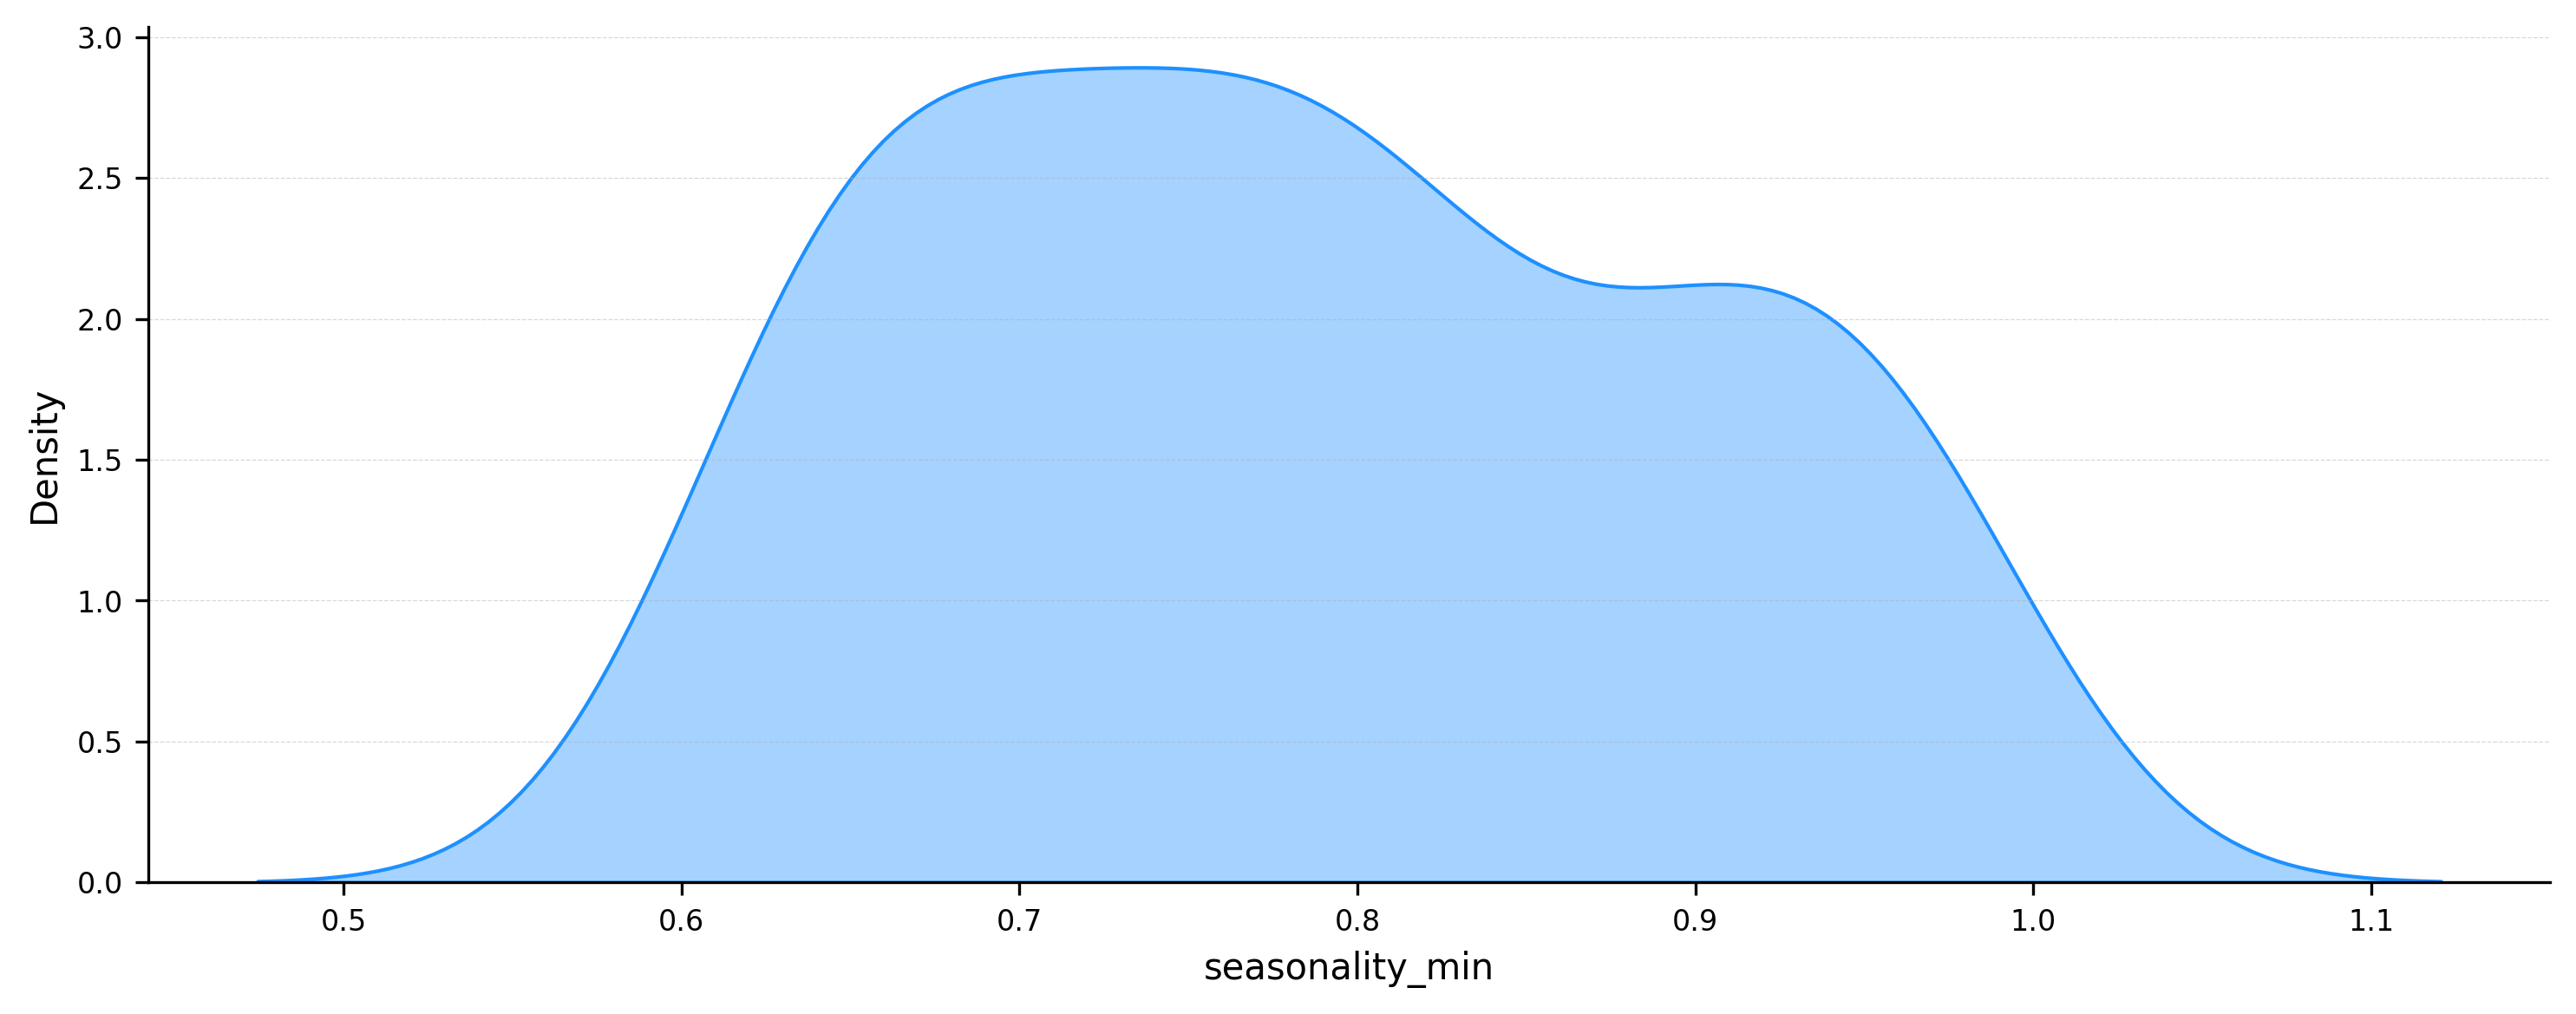

In [17]:
plot_posterior_distribution(results.get_posterior_distribution(), "seasonality_min", kind="kde")

<Axes: title={'center': 'Joint Distribution\nDelta vs I0'}, xlabel='Delta', ylabel='I0'>

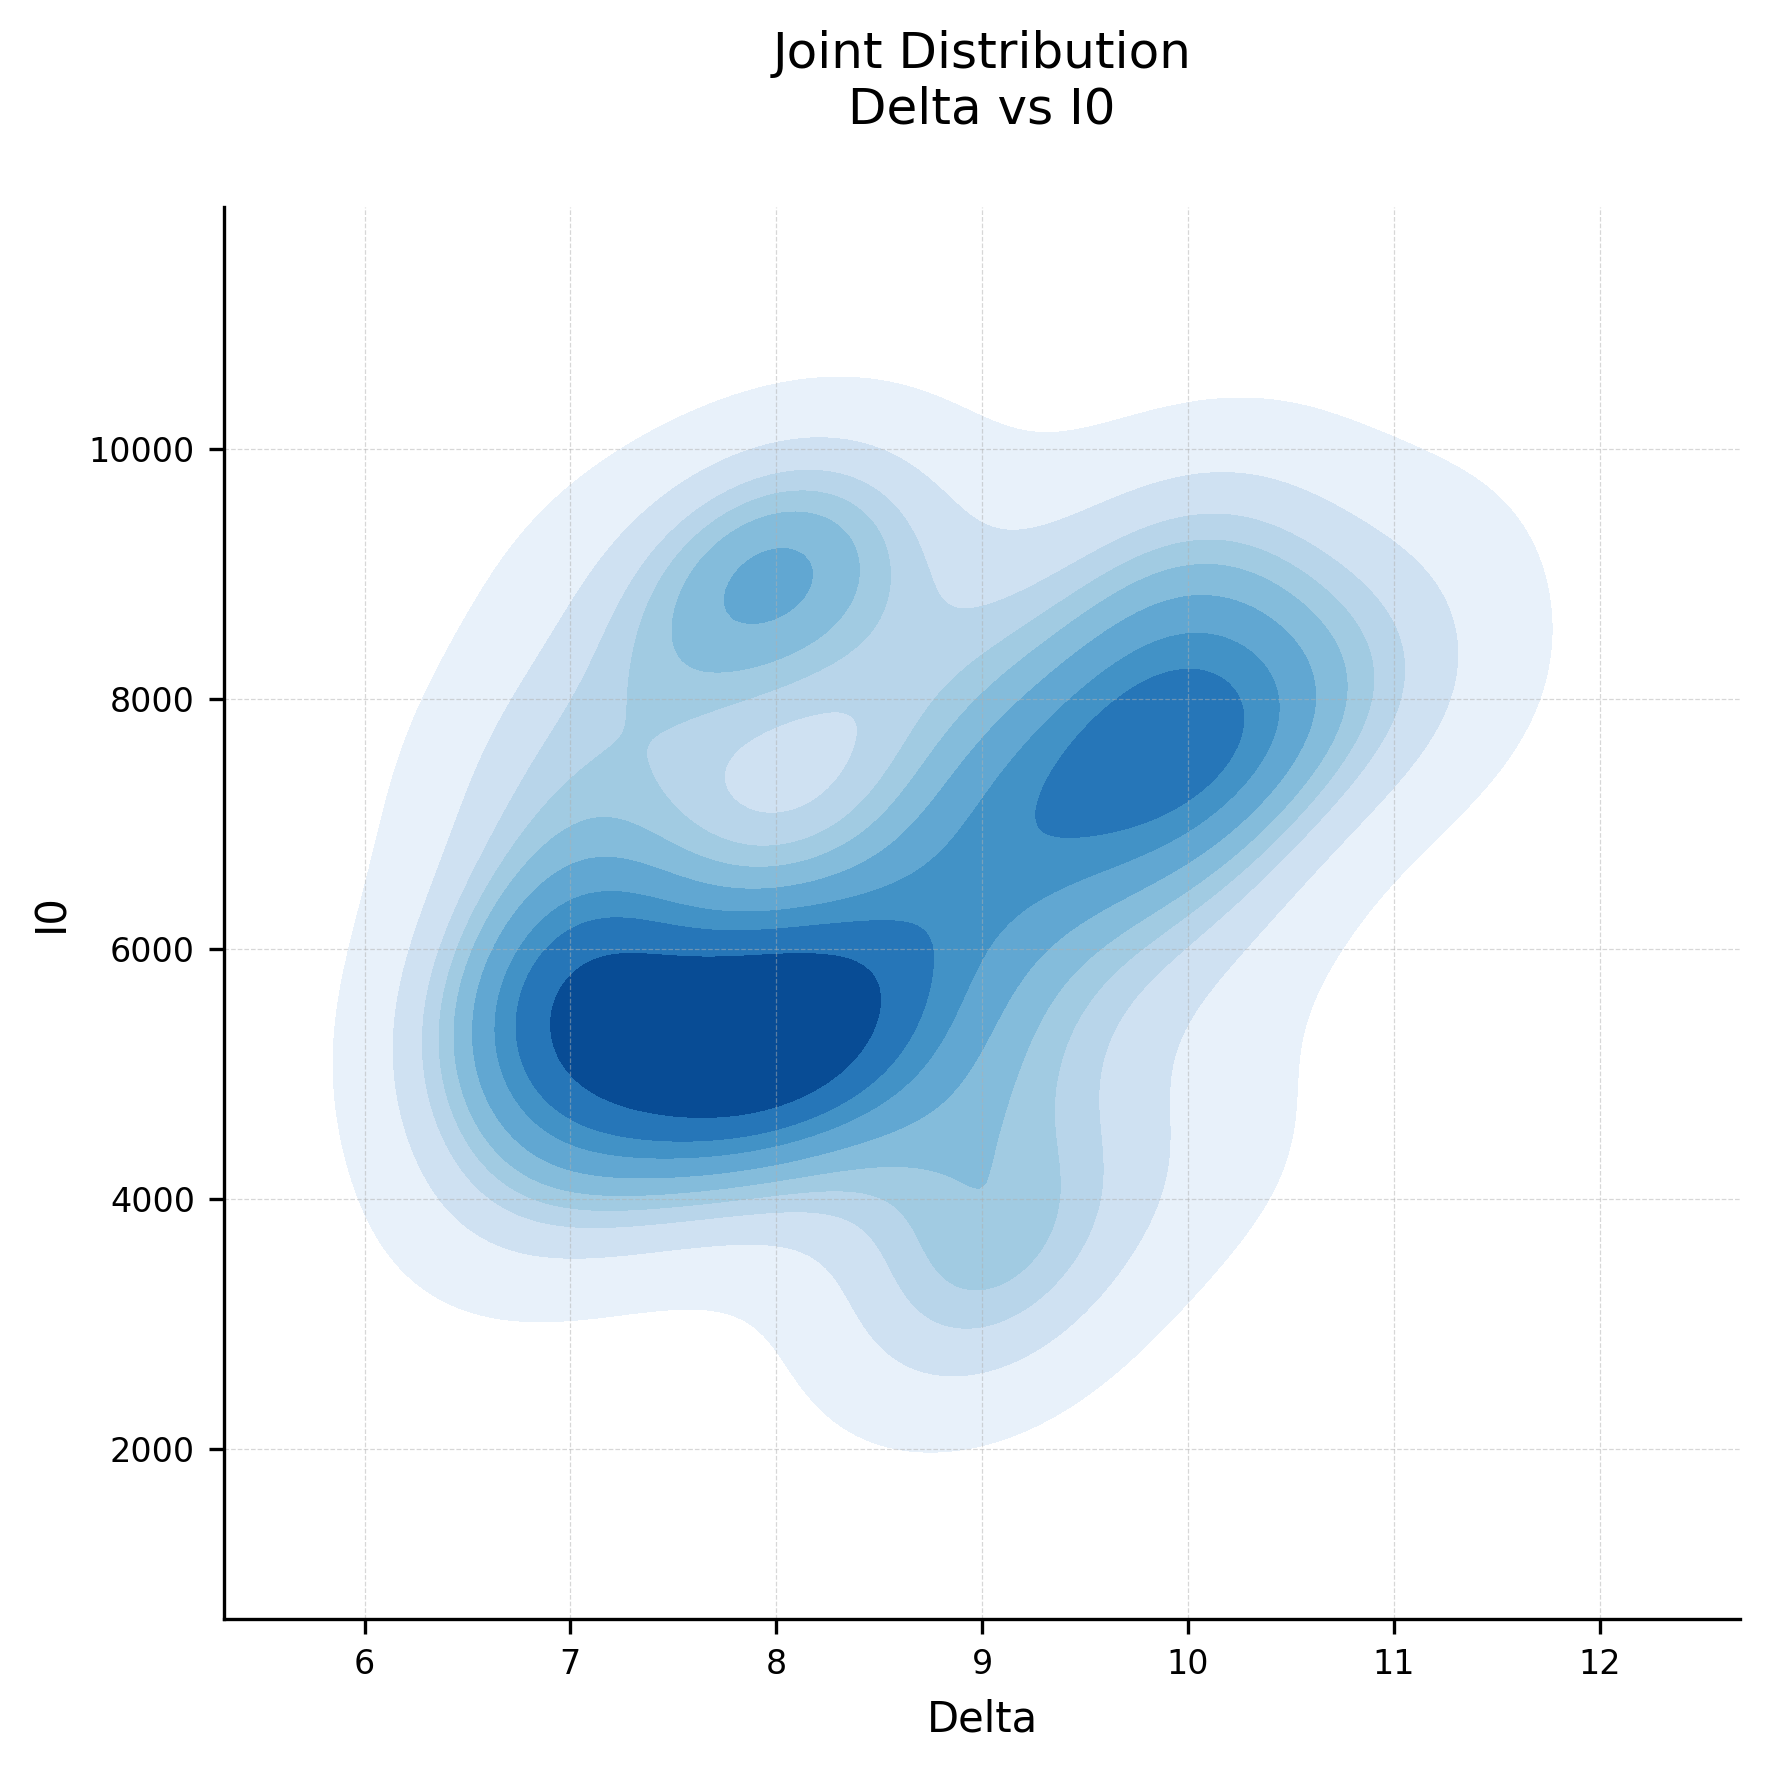

In [18]:
plot_posterior_distribution_2d(results.get_posterior_distribution(), "Delta", "I0", kind="kde")

In [ ]:
np.linalg.eigvals(C).real.max()

In [ ]:
C_p = np.load("./data/ny_state/new_york/contact_matrix/contact_matrix.npz")['arr_0']
np.linalg.eigvals(C_p).real.max()

In [ ]:
epi_data_p = pd.read_csv("./data/ny_state/new_york/epi-data/epi_data.csv")
epi_data_p.date = pd.to_datetime(epi_data_p.date)
epi_data_p.set_index("date", inplace=True)
epi_data_p = epi_data_p.resample("W").sum()
epi_data_p = epi_data_p.loc[(epi_data_p.index >= epi_data.date.values[0]) & (epi_data_p.index <= epi_data.date.values[-1])]
epi_data_p["new_deaths"].plot()
epi_data["data"].plot()

In [68]:
epi_data_p.reset_index(inplace=True)

In [71]:
mob_data = pd.read_csv(f'./data/ny_state/NY_google.csv')
mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])
contact_reductions["date"] = pd.to_datetime(contact_reductions["date"])

In [72]:
from datetime import datetime, timedelta
# merge epi and contacts data 
tot_data = pd.merge(contact_reductions, epi_data_p, how='left', on='date')
tot_data.date = pd.to_datetime(tot_data.date)

# select simulation period
start_date, end_date = datetime(year=2020, month=3, day=8), datetime(year=2020, month=8, day=2)
if start_date - timedelta(days=30) < tot_data.date.min():
        tot_data_simulation = tot_data.loc[tot_data.date <= end_date].reset_index(drop=True)
else:
        tot_data_simulation = tot_data.loc[(tot_data.date >= start_date - timedelta(days=30)) & (tot_data.date <= end_date)].reset_index(drop=True)
tot_data_evaluation = tot_data.loc[(tot_data.date >= start_date) & (tot_data.date <= end_date)].reset_index(drop=True)


In [ ]:
tot_data_evaluation

In [ ]:
tot_data_simulation

In [ ]:
import pyabc
import uuid
import os
from pyabc import RV, Distribution, DiscreteJumpTransition, MultivariateNormalTransition, AggregatedTransition
import tempfile
from pyabc.sampler import MulticoreEvalParallelSampler

def make_model(epimodel, param): 
    def model(p): 
        # run model 
        model_param = {**p, **param}
        return epimodel(model_param)
    return model



def wmape_pyabc(sim_data, actual_data) -> float:
    return np.sum(np.abs(actual_data['data'] - sim_data['data'])) / np.sum(np.abs(actual_data['data']))


pyabc_priors = Distribution(R0=RV("uniform", 1.5, 6.0 - 1.5),
                            Delta=RV('rv_discrete', values=(np.arange(7, 35), [1 / 28] * 28)),
                            I0=RV('rv_discrete', values=(np.arange(10, 10000), [1 / 9990] * 9990)), 
                            seasonality_min=RV("uniform", 0.6, 1.0 - 0.6), 
                            detection_rate=RV("uniform", 0.5, 1.0 - 0.5))

transitions = AggregatedTransition(mapping={"I0": DiscreteJumpTransition(domain=np.arange(10, 10000), p_stay=0.7), 
                                            "R0": MultivariateNormalTransition(), 
                                            "Delta": DiscreteJumpTransition(domain=np.arange(7, 35), p_stay=0.7),
                                            "seasonality_min": MultivariateNormalTransition(), 
                                            "detection_rate": MultivariateNormalTransition()})


abc = pyabc.ABCSMC(make_model(simulate_wrapper, parameters), 
                    pyabc_priors, 
                    distance_function=wmape_pyabc, 
                    transitions=transitions, 
                    population_size=100, 
                    sampler=MulticoreEvalParallelSampler(n_procs=8))

db_path = os.path.join(tempfile.gettempdir(), "test_1.db")
abc.new("sqlite:///" + db_path, {"data": epi_data["data"].values})
history = abc.run(max_nr_populations=7)


In [ ]:
samples = np.array([d["data"] for d in history.get_weighted_sum_stats()[1]])
xs = np.arange(len(samples[0]))
plt.plot(xs, np.median(samples, axis=0))
plt.fill_between(xs, np.percentile(samples, 5.0, axis=0), np.percentile(samples, 95.0, axis=0), alpha=0.2)
plt.plot(xs, epi_data["data"].values, color="black")

epx_res = results.get_calibration_quantiles()

median_epx_res = epx_res.loc[epx_res["quantile"] == 0.5]
plt.plot(xs, median_epx_res["data"], color="red")
plt.fill_between(xs, epx_res.loc[epx_res["quantile"] == 0.05]["data"], epx_res.loc[epx_res["quantile"] == 0.95]["data"], alpha=0.2, color="red")
plt.plot(xs, epi_data["data"].values, color="black")

In [ ]:
posterior_pyabc = history.get_distribution()[0]

import seaborn as sns
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "R0", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "R0", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["R0"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "I0", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "I0", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["I0"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "Delta", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "Delta", kind="kde", color="red", ax=ax)

sns.kdeplot(posterior_pyabc["Delta"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "seasonality_min", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "seasonality_min", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["seasonality_min"], ax=ax)

In [ ]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "detection_rate", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "detection_rate", kind="kde", color="red", ax=ax)

sns.kdeplot(posterior_pyabc["detection_rate"], ax=ax)

In [ ]:
weights_pyabc = history.get_weighted_sum_stats()[0]
weights_epx_rej = results_rejection.get_weights()
weights_epx = results.get_weights()


sns.kdeplot(weights_pyabc, label="PyABC")
sns.kdeplot(weights_epx, label="Epydemix")



In [ ]:
print(np.max(weights_epx))
print(np.max(weights_pyabc))

In [ ]:

posterior_epx_rej = results_rejection.get_posterior_distribution()
posterior_epx = results.get_posterior_distribution()

sns.kdeplot(data=posterior_pyabc, x="I0", y="Delta", cmap="viridis")
plt.show()
sns.kdeplot(data=posterior_epx, x="I0", y="Delta", cmap="viridis")
plt.show()
sns.kdeplot(data=posterior_epx_rej, x="I0", y="Delta", cmap="viridis")
plt.show()


In [ ]:
import seaborn as sns
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "R0", kind="kde")
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "I0", kind="kde")


In [ ]:
blues = sns.color_palette("Blues", 8)
for i in range(8):
    pr = results.get_posterior_distribution(i)
    sns.kdeplot(pr["R0"], color=blues[i], fill=True)
    print(np.median(pr["R0"]))
